### <strong>POPQUORN</strong>
<strong>Po</strong>tato-<strong>P</strong>rolific dataset for <strong>Qu</strong>estion-Answering, <strong>O</strong>ffensiveness, text <strong>R</strong>ewriting and politeness rating with demographic <strong>N</strong>uance

[Source](https://github.com/Jiaxin-Pei/potato-prolific-dataset)
___

Comprises <strong>four NLP tasks</strong>:
1. Offensiveness rating
2. Question Answering
3. Text rewriting / Style transfer
4. Politeness rating

In [1]:
from IPython.display import display, HTML
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import json
import os

%matplotlib inline

In [3]:
path_to_dirs = 'Potato-Prolific-Dataset/dataset'
file_name = 'raw_data.csv'
sample_size=10

tasks = os.listdir(path_to_dirs)
tasks

['offensiveness', 'question_answering', 'politeness_rating', 'email_rewriting']

### <strong>1.</strong> Politeness Rating

In [4]:
path_to_data = f'{path_to_dirs}/{tasks[2]}/{file_name}'

df_politeness = pd.read_csv(path_to_data)
df_politeness

,instance_id,user_id,text,politeness,gender,race,age,occupation,education
0,3104,0,Can you anticipate what's next in the WWF ?\n\...,1.0,Woman,White,25-29,Employed,College degree
1,2888,0,"Good Morning,\n\n\n\nCan you help me prepare a...",3.0,Woman,White,25-29,Employed,College degree
2,3646,0,"Hey Joseph Step,\n\n\n\nI wish you a very merr...",4.0,Woman,White,25-29,Employed,College degree
3,3210,0,"I'll keep reviewing the B plan just in case, b...",4.0,Woman,White,25-29,Employed,College degree
4,3483,0,"Hey bunda,\nHow are you doing this morning?\nI...",2.0,Woman,White,25-29,Employed,College degree
...,...,...,...,...,...,...,...,...,...
25037,200,505,Add J Wolfe to the next report please.,2.0,Man,Black or African American,50-54,Employed,College degree
25038,3465,505,Results - no execute ID know for winner.,1.0,Man,Black or African American,50-54,Employed,College degree
25039,2946,505,"I'm busy on Friday, June 1st. Perhaps you coul...",2.0,Man,Black or African American,50-54,Employed,College degree
25040,3302,505,"Hi Paul,\nAny luck with the draft of the ABB f...",5.0,Man,Black or African American,50-54,Employed,College degree


### 1.1 General stats

In [6]:
# Number of instances, number of annotators

num_inst = df_politeness['instance_id'].nunique()
num_annotr = df_politeness['user_id'].nunique()
annotn_options = sorted(df_politeness['politeness'].unique())

print(f'Number of instances: {num_inst}')
print(f'Number of annotators: {num_annotr}')
print(f'Annotation options: {annotn_options}')

Number of instances: 3718
Number of annotators: 506
Annotation options: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]


In [28]:
# Number of annotations per instance

num_annotn_per_inst = df_politeness.groupby('instance_id')['user_id'].nunique() # or .size() instead of ['user_id'].nunique()
print(f'Number of annotations per instance:\n{num_annotn_per_inst.mean():.2f} MEAN, {num_annotn_per_inst.std():.2f} STD')
print(f'Fewest annotations: {num_annotn_per_inst.min()}')
print(f'Most annotations: {num_annotn_per_inst.max()}')

Number of annotations per instance:
6.74 MEAN, 0.71 STD
Fewest annotations: 3
Most annotations: 8


In [8]:
# Number of annotations per annotator

num_annotn_per_annotr = df_politeness['user_id'].value_counts()
print(f'Number of annotations per annotator:\n{num_annotn_per_annotr.mean():.2f} MEAN, {num_annotn_per_annotr.std():.2f} STD')
print(f'Fewest annotations: {num_annotn_per_annotr.min()}')
print(f'Most annotations: {num_annotn_per_annotr.max()}')

Number of annotations per annotator:
49.49 MEAN, 1.50 STD
Fewest annotations: 36
Most annotations: 50


In [9]:
# Instance text lengths

inst_texts = df_politeness['text'].unique()
inst_text_lengths_char = [len(text) for text in inst_texts]
inst_text_lengths = [len(text.split()) for text in inst_texts]

print(f'Instance text lengths (chars):\n{np.mean(inst_text_lengths_char):.2f} MEAN, {np.std(inst_text_lengths_char):.2f} STD')
print(f'Instance text lengths (words):\n{np.mean(inst_text_lengths):.2f} MEAN, {np.std(inst_text_lengths):.2f} STD')

Instance text lengths (chars):
187.75 MEAN, 136.71 STD
Instance text lengths (words):
34.27 MEAN, 23.85 STD


### 1.2 Sociodemographic information

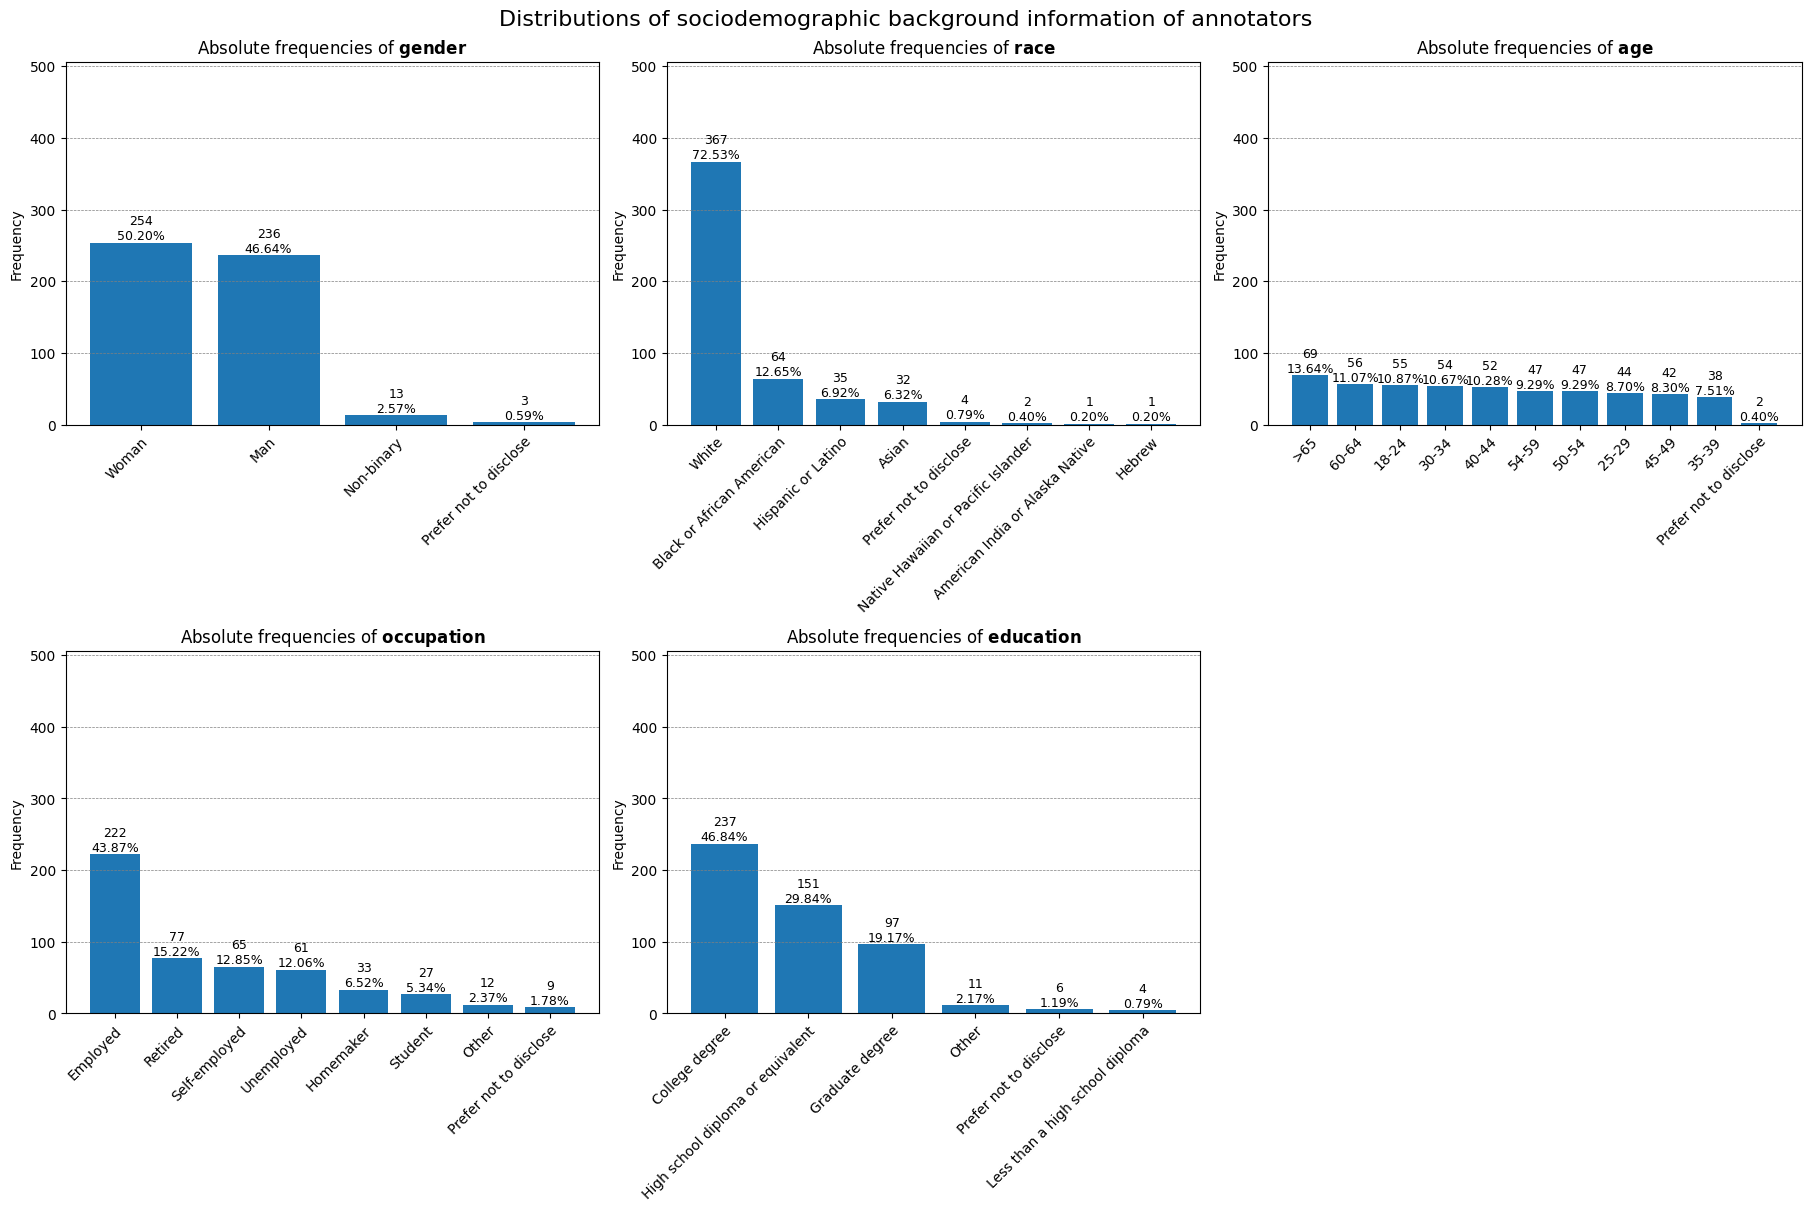

In [10]:
df_politeness_users = df_politeness.drop_duplicates('user_id') # count every annotator once only

# track the frequencies of each sociodemographic attribute's values
meta_dict = {attr: None for attr in df_politeness_users.columns[4:]}

fig, axes = plt.subplots(2, 3, figsize=(18,12), constrained_layout=True)
fig.suptitle("Distributions of sociodemographic background information of annotators", fontsize=16)
axes = axes.flatten()
axes[5].axis('off') # remove unused sixth subplot

for i, column in enumerate(df_politeness_users.columns[4:]):
    
    abs_freqs = df_politeness_users[column].value_counts()
    rel_freqs = df_politeness_users[column].value_counts(normalize=True)
  
    bars = axes[i].bar(abs_freqs.index, abs_freqs.values)
    axes[i].set_title(rf'Absolute frequencies of $\bf{{{column}}}$')
    axes[i].set_ylabel('Frequency')
    axes[i].set_ylim(0, num_annotr)
    
    meta_dict[column] = dict(map(lambda i,j : (i,j) , rel_freqs.index, rel_freqs.values))
    
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        label.set_rotation_mode('anchor')

    # label the bars with the absolute and relative frequency values
    for bar, abs_freq, rel_freq in zip(bars, abs_freqs, rel_freqs):
        # save the frequencies for later
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{abs_freq}\n{rel_freq*100:.2f}%',
            ha='center',
            va='bottom',
            fontsize=9)    
    
    # add horizontal lines
    for y in axes[i].get_yticks():
        axes[i].axhline(y=y, color='gray', linestyle='--', linewidth=0.5)
        
plt.show()

### 1.3 Annotations, Disagreement

### 1.3.1 Example annotation distributions

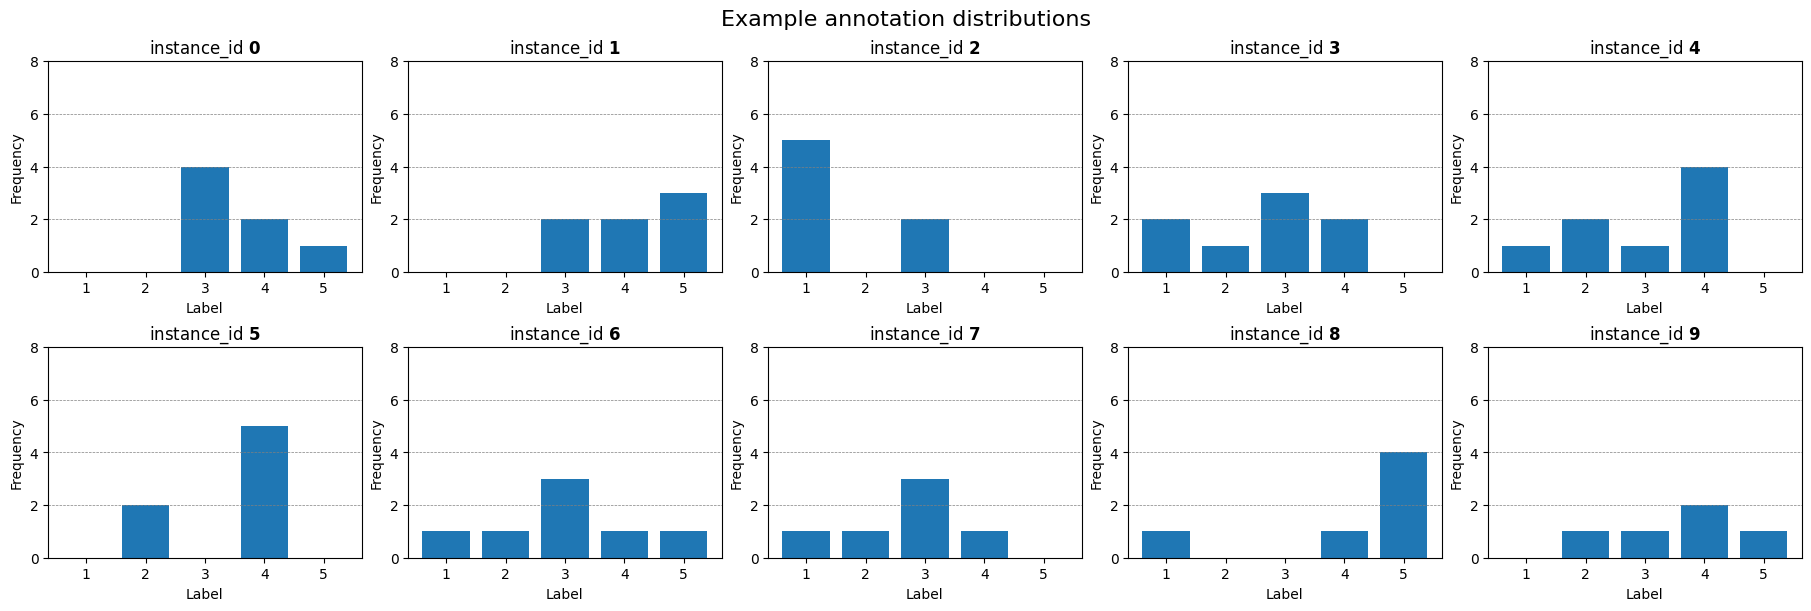

In [11]:
# Some example annotation distributions

df_politeness_per_inst = df_politeness.groupby('instance_id')['politeness'].apply(list).reset_index()

def aggregate_annotations(annotn):
    annotn_dict = dict.fromkeys(annotn_options, 0)
    for a in annotn:
        annotn_dict[a] += 1 
    return annotn_dict

def plot(inst_id_list, title):
    nrows = 2 if len(inst_id_list) > 5 else 1
    fig, axes = plt.subplots(nrows, 5, figsize=(18,3*nrows), constrained_layout=True)
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    for i, inst in enumerate(inst_id_list):
        inst = df_politeness_per_inst.loc[inst]
        instance_id = inst['instance_id']
        annotn_dict = aggregate_annotations(inst['politeness'])

        bars = axes[i].bar(annotn_dict.keys(), annotn_dict.values())
        axes[i].set_title(rf'instance_id $\bf{{{instance_id}}}$')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Frequency')
        axes[i].set_ylim(0, num_annotn_per_inst.max())

        # add horizontal lines
        for y in axes[i].get_yticks():
            axes[i].axhline(y=y, color='gray', linestyle='--', linewidth=0.5)
    
    upper = int(sample_size/2) if nrows == 1 else sample_size
    for j in range(len(inst_id_list), upper):
        axes[j].axis('off')
    
    plt.show()
    
plot([i for i in range(sample_size)], "Example annotation distributions")

### 1.3.2 Perfect agreement

In [12]:
# Perfect agreement

perfect_agreement = df_politeness_per_inst[df_politeness_per_inst['politeness'].apply(lambda x: len(set(x)) == 1.0)]
perfect_agreement_besides_1 = perfect_agreement['politeness'].apply(lambda x: any(item != 1.0 for item in x))

print(f'Number of instances with perfect agreement: {len(perfect_agreement)}')
print(f'Number of instances with perfect agreement besides label 1.0: {len(perfect_agreement[perfect_agreement_besides_1])}')
print(f'Number of instances with disagreement: {num_inst - len(perfect_agreement)}')

Number of instances with perfect agreement: 67
Number of instances with perfect agreement besides label 1.0: 40
Number of instances with disagreement: 3651


### 1.3.3 Disagreement

In [13]:
# Disagreement

def gini(annotn):
    sum_ = 0
    unique_vals = list(set(annotn))
    for val in unique_vals:
        sum_ += (annotn.count(val)/len(annotn))**2
    return round(1 - sum_, 3)

$Gini = 1-\sum_{i=1}^n(p_i)^2$

The [Gini Index](https://www.javatpoint.com/gini-index-in-machine-learning) is a proportion of impurity or inequality in statistical and monetary settings. In machine learning, it is utilized as an impurity measure in decision tree algorithms for classification tasks. The higher, the more impure.

In [14]:
df_politeness_gini = df_politeness_per_inst['politeness'].apply(gini).reset_index()
df_politeness_gini.columns = ['instance_id', 'gini_index']
df_politeness_gini = df_politeness_gini.sort_values(by=['gini_index'], ascending=False)

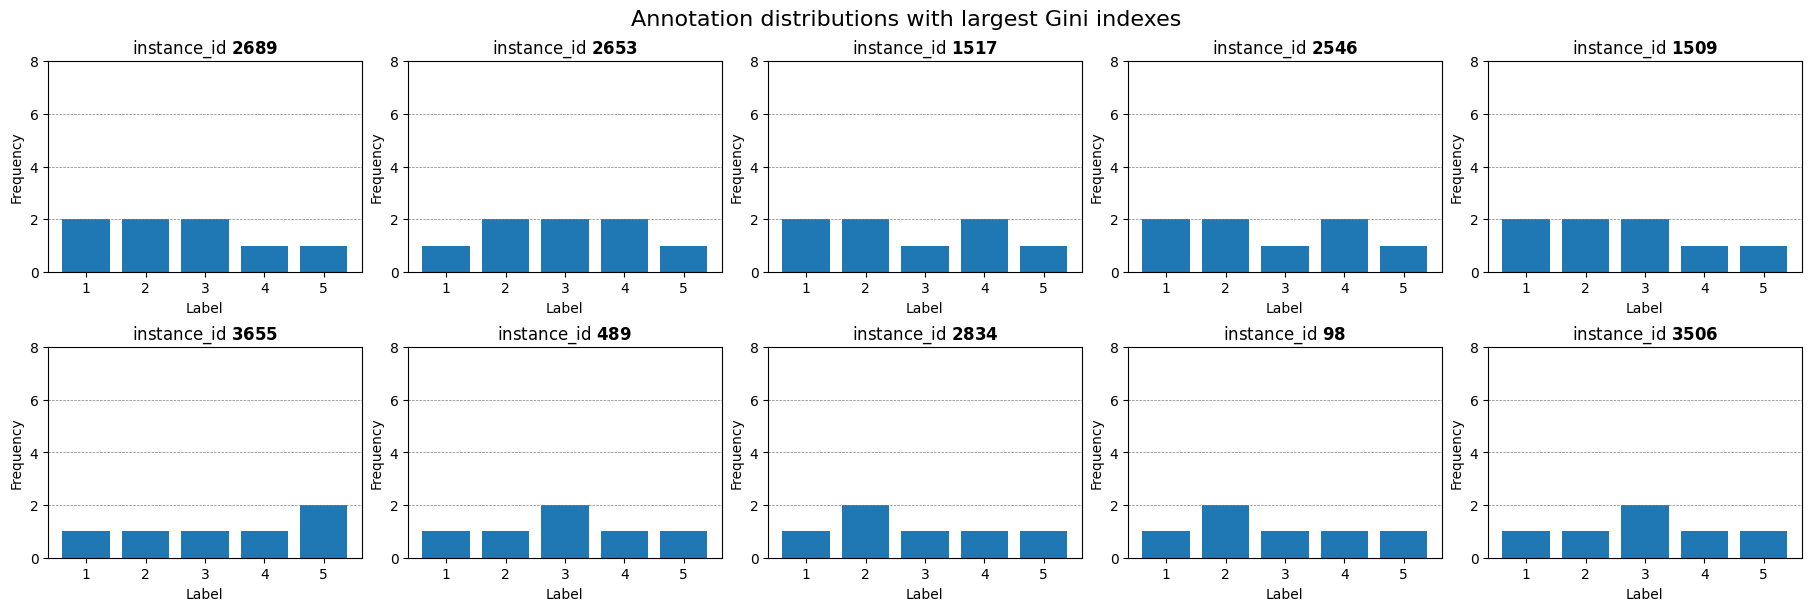

In [15]:
plot(df_politeness_gini['instance_id'][:sample_size], "Annotation distributions with largest Gini indexes")

### 1.3.4 Single majority label

Number of instances with a single majority, thresh=1: 3017
Number of instances with a single majority, thresh=2: 1747
Number of instances with a single majority, thresh=3: 958
Number of instances with a single majority, thresh=4: 498
Number of instances with a single majority, thresh=5: 209


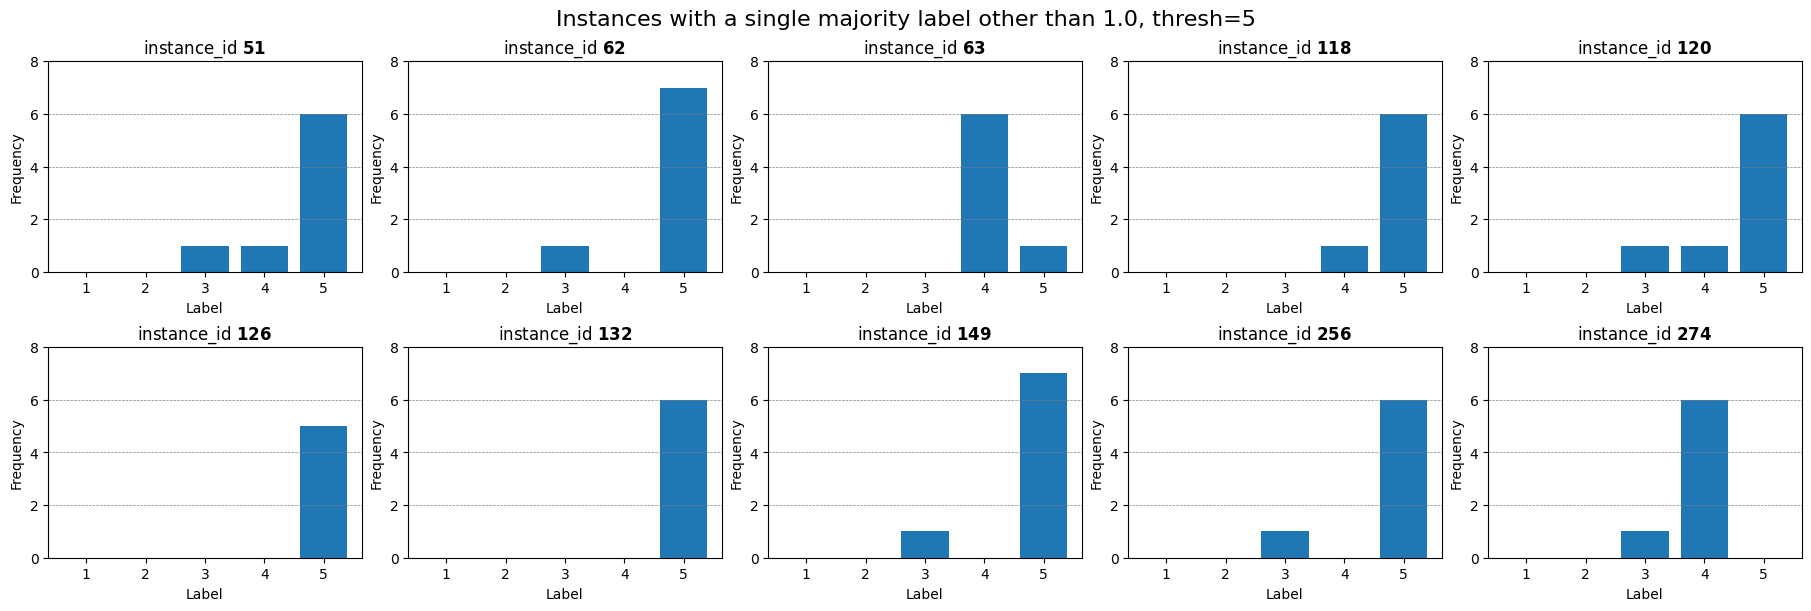

In [19]:
# Instances with a single majority

def get_majority_labels(d):
    max_value = max(d.values())
    # if there are multiple labels with the same highest count, return them all, though the single majority condition is not fulfilled
    maj_labels = [key for key, value in d.items() if value == max_value]
    return maj_labels[0] if len(maj_labels) == 1 else maj_labels

def has_single_majority(annotn, thresh):
    annotn_dict = dict.fromkeys(annotn_options, 0)
    for a in annotn:
        annotn_dict[a] += 1
    annotn_dict_sorted = dict(sorted(annotn_dict.items(), key=lambda x: x[1], reverse=True))
    counts = list(annotn_dict_sorted.values())
    majority_labels = get_majority_labels(annotn_dict_sorted)
    cond = counts[0] >= counts[1] + thresh
    return majority_labels, cond


thresholds = [1, 2, 3, 4, 5]
verbose = False

for thresh in thresholds:
    df_politeness_single_majority = df_politeness_per_inst['politeness'].apply(has_single_majority, thresh=thresh).reset_index()
    df_politeness_single_majority[['majority_labels', 'has_single_majority']] = df_politeness_single_majority['politeness'].apply(pd.Series)
    df_politeness_single_majority.drop(columns=['politeness'], inplace=True)

    df_politeness_single_majority = df_politeness_single_majority[df_politeness_single_majority.has_single_majority]
    sample = df_politeness_single_majority['index'][:sample_size] # index corresponds to instance_id
    print(f'Number of instances with a single majority, thresh={thresh}: {len(df_politeness_single_majority)}')
    
    distr = df_politeness_single_majority['majority_labels'].value_counts().reset_index()
    if verbose:
        display(distr)
    
    if thresh == 5:
        # plot(sample, f'Example instances with a single majority, thresh={thresh}')
        
        # take a closer look at the instamces with a single majority label other than 1
        ids = df_politeness_single_majority.loc[df_politeness_single_majority['majority_labels'] != 1.0, 'index'][:10]
        plot(ids, f'Instances with a single majority label other than 1.0, thresh={thresh}')
        if verbose: 
            for id_ in ids:
                display(df_politeness.loc[df_politeness['instance_id'] == id_][['text', 'politeness']].reset_index())

### 1.3.5 Annotation variety

In [20]:
# Annotation variety

# Aggregate the sociodem. meta information for each instance's annotators (for 1.3.6)
df_politeness_per_inst_meta = df_politeness.groupby('instance_id').agg({
    'politeness': list,
    'gender': list,
    'race': list,
    'age': list,
    'occupation': list,
    'education': list
}).reset_index()

In [21]:
df_politeness_per_inst_meta['num_different_labels'] = df_politeness_per_inst_meta['politeness'].apply(lambda x: len(set(x)))
df_politeness_labels = df_politeness_per_inst_meta['num_different_labels'].value_counts().reindex([1,2,3,4,5]).reset_index()
df_politeness_labels

,num_different_labels,count
0,1,67
1,2,757
2,3,1828
3,4,965
4,5,101


### 1.3.6 Links to sociodemographic background information

Since annotators vary per instance, look at relations on an instance level first

In [22]:
df_politeness_per_inst_meta_gini = pd.merge(df_politeness_per_inst_meta, df_politeness_gini, on='instance_id')
df_politeness_per_inst_meta_gini

,instance_id,politeness,gender,race,age,occupation,education,num_different_labels,gini_index
0,0,"[4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 3.0]","[Man, Woman, Man, Woman, Woman, Man, Man]","[White, White, White, White, White, Native Haw...","[18-24, 35-39, 35-39, 35-39, >65, 40-44, 54-59]","[Student, Employed, Employed, Self-employed, R...","[High school diploma or equivalent, College de...",3,0.571
1,1,"[3.0, 4.0, 3.0, 5.0, 4.0, 5.0, 5.0]","[Man, Non-binary, Prefer not to disclose, Man,...","[White, White, Prefer not to disclose, White, ...","[30-34, 30-34, Prefer not to disclose, 54-59, ...","[Prefer not to disclose, Employed, Prefer not ...","[Prefer not to disclose, Graduate degree, Pref...",3,0.653
2,2,"[1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0]","[Man, Woman, Woman, Man, Woman, Man, Non-binary]","[Prefer not to disclose, Black or African Amer...","[35-39, 54-59, 30-34, 60-64, >65, 60-64, 25-29]","[Self-employed, Other, Homemaker, Self-employe...","[College degree, High school diploma or equiva...",2,0.408
3,3,"[3.0, 3.0, 4.0, 1.0, 1.0, 3.0, 2.0, 4.0]","[Man, Man, Man, Man, Woman, Man, Woman, Woman]","[White, White, White, White, Black or African ...","[45-49, 18-24, >65, 35-39, 40-44, 40-44, 60-64...","[Employed, Employed, Retired, Employed, Unempl...","[Graduate degree, High school diploma or equiv...",4,0.719
4,4,"[4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 2.0, 1.0]","[Man, Man, Woman, Man, Man, Woman, Man, Man]","[White, Hispanic or Latino, White, White, Whit...","[35-39, 18-24, 40-44, 35-39, 50-54, 60-64, 54-...","[Unemployed, Employed, Employed, Employed, Emp...","[High school diploma or equivalent, High schoo...",4,0.656
...,...,...,...,...,...,...,...,...,...
3713,3713,"[2.0, 3.0, 4.0, 2.0, 4.0, 3.0, 2.0]","[Woman, Woman, Man, Woman, Woman, Man, Woman]","[White, White, White, White, Asian, White, White]","[35-39, 25-29, 35-39, 18-24, 18-24, 60-64, 60-64]","[Unemployed, Employed, Employed, Unemployed, S...","[High school diploma or equivalent, College de...",3,0.653
3714,3714,"[3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 4.0]","[Man, Woman, Woman, Woman, Woman, Woman, Woman...","[White, White, White, White, White, White, Whi...","[35-39, 40-44, 40-44, 60-64, 45-49, 60-64, 60-...","[Student, Homemaker, Employed, Self-employed, ...","[College degree, High school diploma or equiva...",3,0.531
3715,3715,"[3.0, 3.0, 5.0, 3.0, 4.0, 3.0, 5.0]","[Prefer not to disclose, Woman, Woman, Woman, ...","[White, Black or African American, White, Whit...","[30-34, 35-39, 40-44, 50-54, 50-54, >65, 50-54]","[Self-employed, Homemaker, Employed, Retired, ...","[College degree, College degree, College degre...",3,0.571
3716,3716,"[3.0, 3.0, 4.0, 3.0, 4.0, 2.0, 4.0]","[Man, Man, Man, Man, Woman, Woman, Man]","[Black or African American, Asian, Black or Af...","[18-24, 45-49, 40-44, 54-59, 18-24, 54-59, 60-64]","[Employed, Homemaker, Employed, Employed, Stud...","[High school diploma or equivalent, Graduate d...",3,0.612


In [23]:
# Let us (for now) quantify disagreement using the number of different labels given on an instance
# 1 -> no disagreement, up to 5 -> complete disagreement

# for each of the five different numbers of different labels instances can have,
# go over all instances that apply and, for each value of each sociodemographic attribute, 
# sum up the frequencies in which they occur across those instances, overage them and compare it with the 
# true frequency in meta_dict.
def count_freqs(list_, attr, dict_):
    for val in dict_[attr].keys():
        dict_[attr][val] += list_.count(val) / len(list_)
    return dict_

meta_dict_full = dict()

for _, row in df_politeness_labels.iterrows():
    meta_dict_ = {attr: {val: 0 for val in meta_dict[attr].keys()} for attr in meta_dict.keys()}
    df = df_politeness_per_inst_meta_gini[df_politeness_per_inst_meta_gini['num_different_labels'] == row.iloc[0]]

    l = df.columns.get_loc('gender')
    r = df.columns.get_loc('education')
    for attr in df.columns[l:r+1]:
        meta_dict_sums = df[attr].apply(count_freqs, attr=attr, dict_=meta_dict_)
    
    meta_dict_sums = meta_dict_sums.iloc[0]
    for attr, val_dict in meta_dict_sums.items():
        meta_dict_sums[attr] = {k: v / row.iloc[1] for k, v in val_dict.items()}

    meta_dict_full[int(row.iloc[0])] = meta_dict_sums

In [25]:
for i in meta_dict_full.keys():
    print(f'================= {i} different label(s) =================')
    print(json.dumps({
    outer_key: {key: meta_dict[outer_key][key] - meta_dict_full[i][outer_key][key] 
                for key in meta_dict[outer_key]} 
    for outer_key in meta_dict
    }, sort_keys=True, indent=4))

# value above 0 -> that attribute value has appeared less frequently than the average
# value below 0 -> that attribute value has appeared more frequently than the average

================= 1 different label(s) =================
{
    "age": {
        "18-24": -0.0038665368808133427,
        "25-29": -0.019102469021352902,
        "30-34": -0.0020581732781603385,
        "35-39": 0.002817364335858802,
        "40-44": -0.011447842661340427,
        "45-49": 0.00960309969070515,
        "50-54": 0.0010232575125501686,
        "54-59": 0.009267749339131548,
        "60-64": 0.014687572864081608,
        ">65": -0.004876591070620939,
        "Prefer not to disclose": 0.003952569169960474
    },
    "education": {
        "College degree": -0.0071002974961443255,
        "Graduate degree": 0.014443030471583324,
        "High school diploma or equivalent": -0.027504979338204394,
        "Less than a high school diploma": 0.005417576150866222,
        "Other": 0.007151355026111675,
        "Prefer not to disclose": 0.007593315185787606
    },
    "gender": {
        "Man": 0.038329245921718325,
        "Non-binary": -0.007090816386728132,
        "Prefer not t